In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import pickle as p
import equinox as eqx
import optax
import functools as ft

In [3]:
from dLux import *
from helpers import *
from bayes import *

from tqdm.notebook import tqdm
from dLux.zernike import zernike_basis
from model_layers import toliman_layers
from plotting import plot_batch
from chainconsumer import ChainConsumer

In [4]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.facecolor'] = 'w'
# plt.rcParams.keys()

<Figure size 432x288 with 0 Axes>

In [5]:
r = arcsec2rad(10)
positions = np.array([[r/2, 0], [-r/2, 0]])
fluxes = np.array([1e6, 1e6])
wavels = 1e-9 * np.linspace(545, 645, 9)

In [6]:
# # Base layers
lays = toliman_layers()
aperture = lays[2].array
wf_npix = aperture.shape[0]

# # Zernike Basis
zern_basis = zernike_basis(10, wf_npix, outside=0.)[3:]
zcoeffs = np.zeros(len(zern_basis))

# Detector Layers
jitter = 1.
saturation = 1e6
det_layers = [ApplyJitter(jitter), ApplySaturation(saturation)]
det_layers = []

In [7]:
basis = np.load("files/basis.npy")
wavels = 1e-9 * np.linspace(595, 695, 6)

In [8]:
ppf = get_ppf(wavels)
min_fringe = 1
max_fringe = 10

rmin = min_fringe/ppf
rmax = max_fringe/ppf
print(rmin, rmax)

5.239384615384616 52.39384615384616


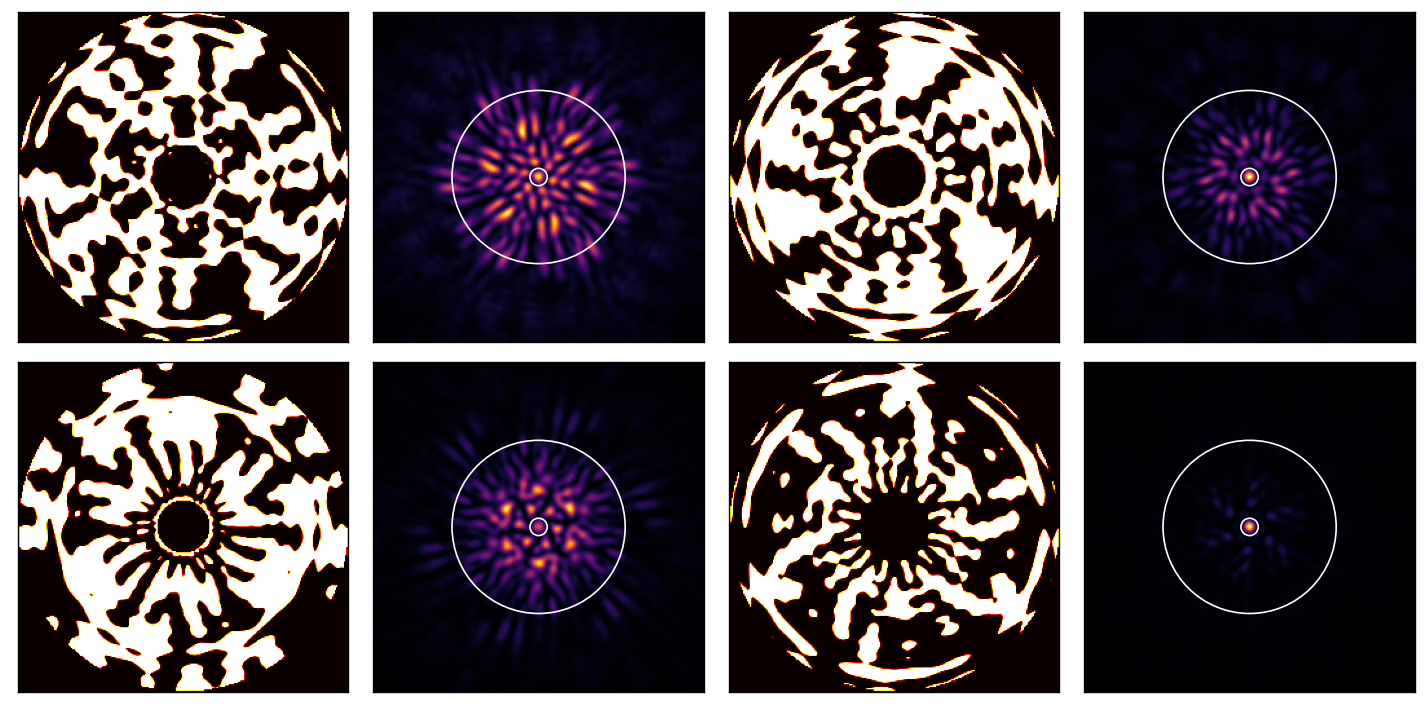

In [9]:
nseeds = 4
osyses = []
for i in range(nseeds):
    onp.random.seed(i)
    coeffs = norm_rand(0, 100, [len(basis)])
    
    latent_layers = toliman_layers([
                            ApplyBasisCLIMB(basis, coeffs, np.mean(wavels)),
                            ApplyBasisOPD(zern_basis, zcoeffs)],
                            det_npix=200)
    osyses.append(OpticalSystem(latent_layers, 
                                wavels=wavels, 
                                positions=positions, 
                                fluxes=fluxes,
                                detector_layers=det_layers))
    
plot_batch(osyses, rmin=rmin, rmax=rmax, rmask=True, single=True)

In [10]:
from jax.scipy.stats import norm

def perturb_r_phi(positions, r_shift, phi_shift):
    """
    Perturbs binary by separation and angle
    """
    p0, p1 = positions
    dp = p1 - p0
    r, phi = cart2polar(dp[0], dp[1])
    
    r += r_shift
    phi += phi_shift
    shift = polar2cart(r, phi)
    
    positions = np.array([p1 - shift, p0 + shift])
    return positions

def perturb_flux(fluxes, cont_shift):
    """
    Perturbs binary by contrast
    """
    f0, f1 = fluxes
    cont = fluxes[0]/fluxes[1]
    cont += cont_shift
    fluxes = np.array([cont*f1, f0/cont])
    return fluxes

def binary_param(X, model, get_params=False, prior=False):
    
    if get_params:
        X = np.zeros(100)
    indx = 0
    params = []
    
    # Positions
    r_shift = arcsec2rad(X[indx])
    r_shift *= 1 if prior else 1
    phi_shift = arcsec2rad(X[indx+1])
    phi_shift *= 1 if prior else 1
    positions = perturb_r_phi(model.positions, r_shift, phi_shift)
    model = eqx.tree_at(lambda model: model.positions, model, positions)
    params+= ["r (arcsec)", "$\phi (arcsec)$"]
    indx += 2
    
    # Fluxes
    cont_shift = X[indx]
    cont_shift *= 1 if prior else 1
    fluxes = perturb_flux(model.fluxes, cont_shift)
    model = eqx.tree_at(lambda model: model.fluxes, model, fluxes)
    params.append('$f_A/f_B$')
    indx += 1
    
    # Wavel
    wavel_shift = X[indx]
    wavel_shift *= norm.pdf(X[indx],  scale=1) if prior else 1
    wavels = model.wavels + (wavel_shift * 1e-9)
    model = eqx.tree_at(lambda model: model.wavels, model, wavels)
    params.append("$\lambda (nm)$")
    indx += 1
    
    # Plate scale
    pscale = X[indx]
    pscale *= norm.pdf(X[indx]) if prior else 1
    pscale = model.layers[-1].pixel_scale_out + (pscale)
    model = eqx.tree_at(lambda model: model.layers[-1].pixel_scale_out, model, pscale)
    params.append("Pscale (m)")
    indx += 1
    
    
    ###################################
    # Coeffs
    coeffs = model.layers[-2].coeffs
    
    # Evens
    coeff_shift = X[indx:indx+3]
    coeffs = coeffs.at[:3].add((coeff_shift * 1e-9))
    params += ["Defoc", "AstigX", "AstigY"]
    indx += 3
    
    # Odds
    coeff_shift = X[indx:indx+4]
    coeffs = coeffs.at[3:].add((coeff_shift * 1e-9))
    params += ["ComaX", "ComaY", "TfoilX", "TfoilY"]
    indx += 4
    
    # Update Coeffs
    model = eqx.tree_at(lambda model: model.layers[-2].coeffs, model, coeffs)
    ##################################
    
    if get_params:
        return np.zeros(indx), params
    return model

def apply_binary_params(X, model, prior=False):
    return binary_param(X, model, prior=prior)

In [11]:
# Default values to group 0
filter_spec = jax.tree_map(lambda _: False, osyses)

# Set filtering Tree
for i in range(len(osyses)):
    filter_spec[i] = eqx.tree_at(lambda osys: osys.layers[4].coeffs, filter_spec[i], replace=True)
    
@eqx.filter_jit
@ft.partial(eqx.filter_value_and_grad, arg=filter_spec)
def batch_loss_func(models, X, logpri_fn, update_fn):
    loss = 0
    for i in range(len(models)):
        model = models[i]
        psf = model()
        loss += calc_ent(logpri_fn, X, psf, model, update_fn)
    return loss

In [12]:
%%time
X, params = binary_param(None, osyses[0], get_params=True)
loss, grads = batch_loss_func(osyses, X, poiss_logpri, binary_param)
print("Initial Loss: {}".format(loss))

Initial Loss: -191.90173797409136
CPU times: user 2min 50s, sys: 4.31 s, total: 2min 54s
Wall time: 2min 5s


In [13]:
optim = optax.adam(1e1)

model = osyses
opt_state = optim.init(model)

errors, grads_out, models_out = [], [], []
for i in tqdm(range(50)):
    loss, grads = batch_loss_func(model, X, poiss_logpri, binary_param)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    models_out.append(model)
    errors.append(loss)
    grads_out.append(grads)
    
    if i<10 or i%10 == 0:
        print("Epoch: {} Loss: {:.3f}".format(i, 1e3*loss))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss: -191901.738
Epoch: 1 Loss: -194932.557
Epoch: 2 Loss: -197427.540
Epoch: 3 Loss: -199427.961
Epoch: 4 Loss: -201063.290
Epoch: 5 Loss: -202384.833
Epoch: 6 Loss: -203413.563
Epoch: 7 Loss: -204264.568
Epoch: 8 Loss: -205076.907
Epoch: 9 Loss: -205789.935
Epoch: 10 Loss: -206458.628
Epoch: 20 Loss: -209332.558
Epoch: 30 Loss: -211070.766
Epoch: 40 Loss: -212277.750


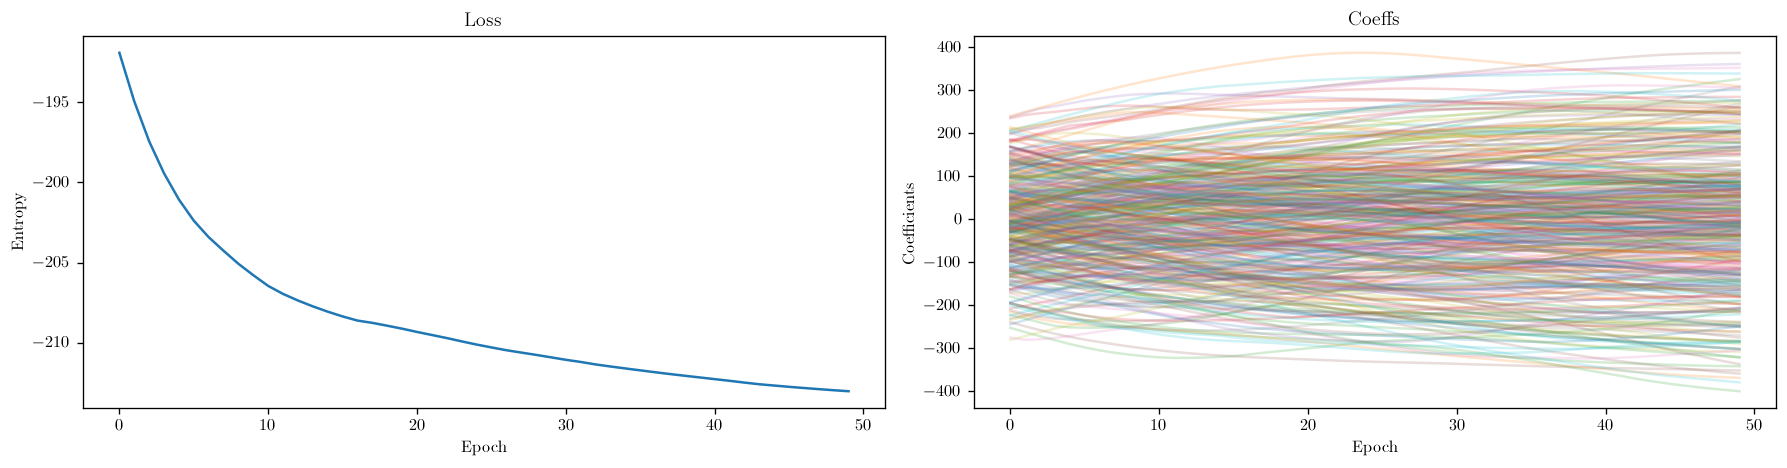

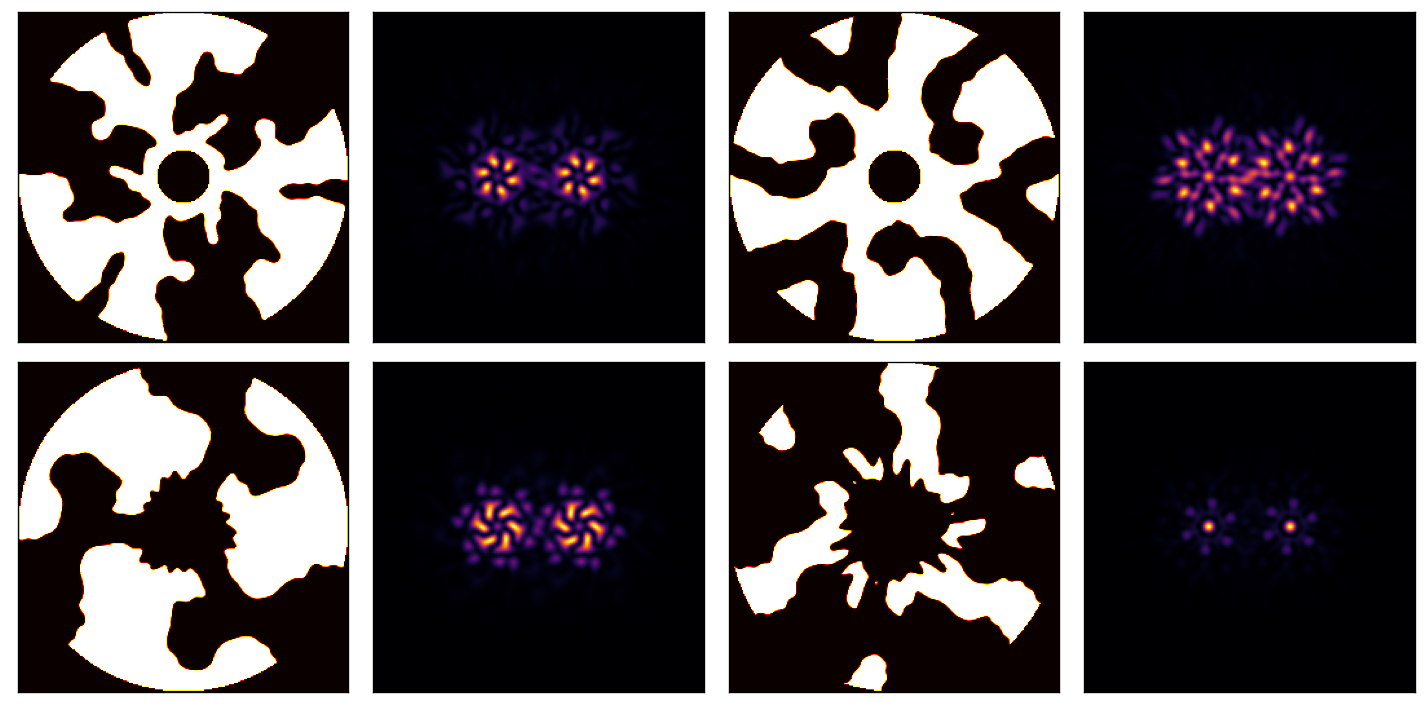

In [17]:
coeffs_out = np.array([[model[i].layers[4].coeffs for i in range(len(model))] for model in models_out])

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(np.array(errors))
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Entropy")

plt.subplot(1, 2, 2)
plt.title("Coeffs")
for i in range(len(models_out[-1])):
    plt.plot(coeffs_out[:, i], alpha=0.2)
plt.xlabel("Epoch")
plt.ylabel("Coefficients")
    
plt.tight_layout()
# plt.savefig("files/errors", facecolor='w')
plt.show()

plot_batch(models_out[-1])

In [18]:
final_model = models_out[-1]
covs = [calc_cov(poiss_logpri, X, final_model[i](), final_model[i], binary_param) for i in tqdm(range(len(final_model)))]

  0%|          | 0/4 [00:00<?, ?it/s]

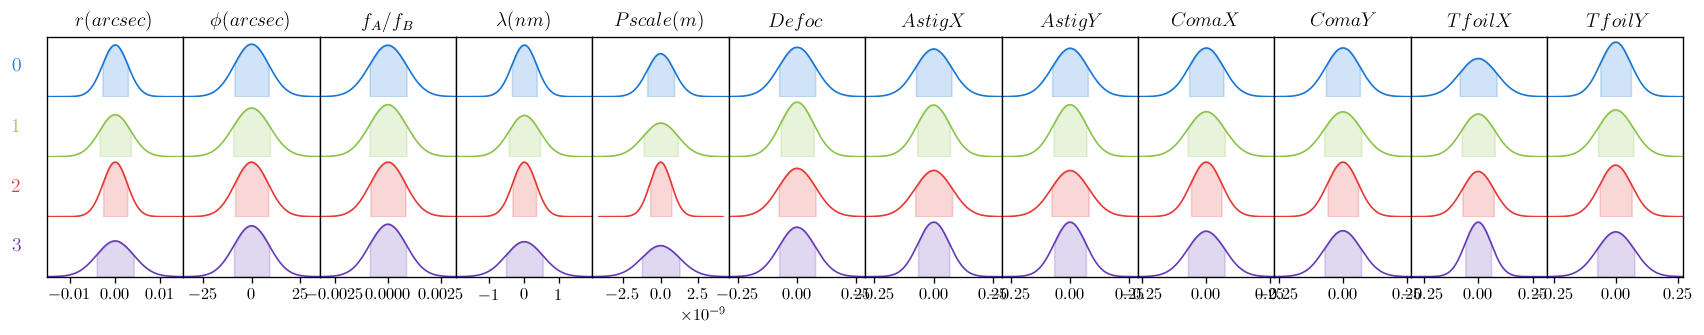

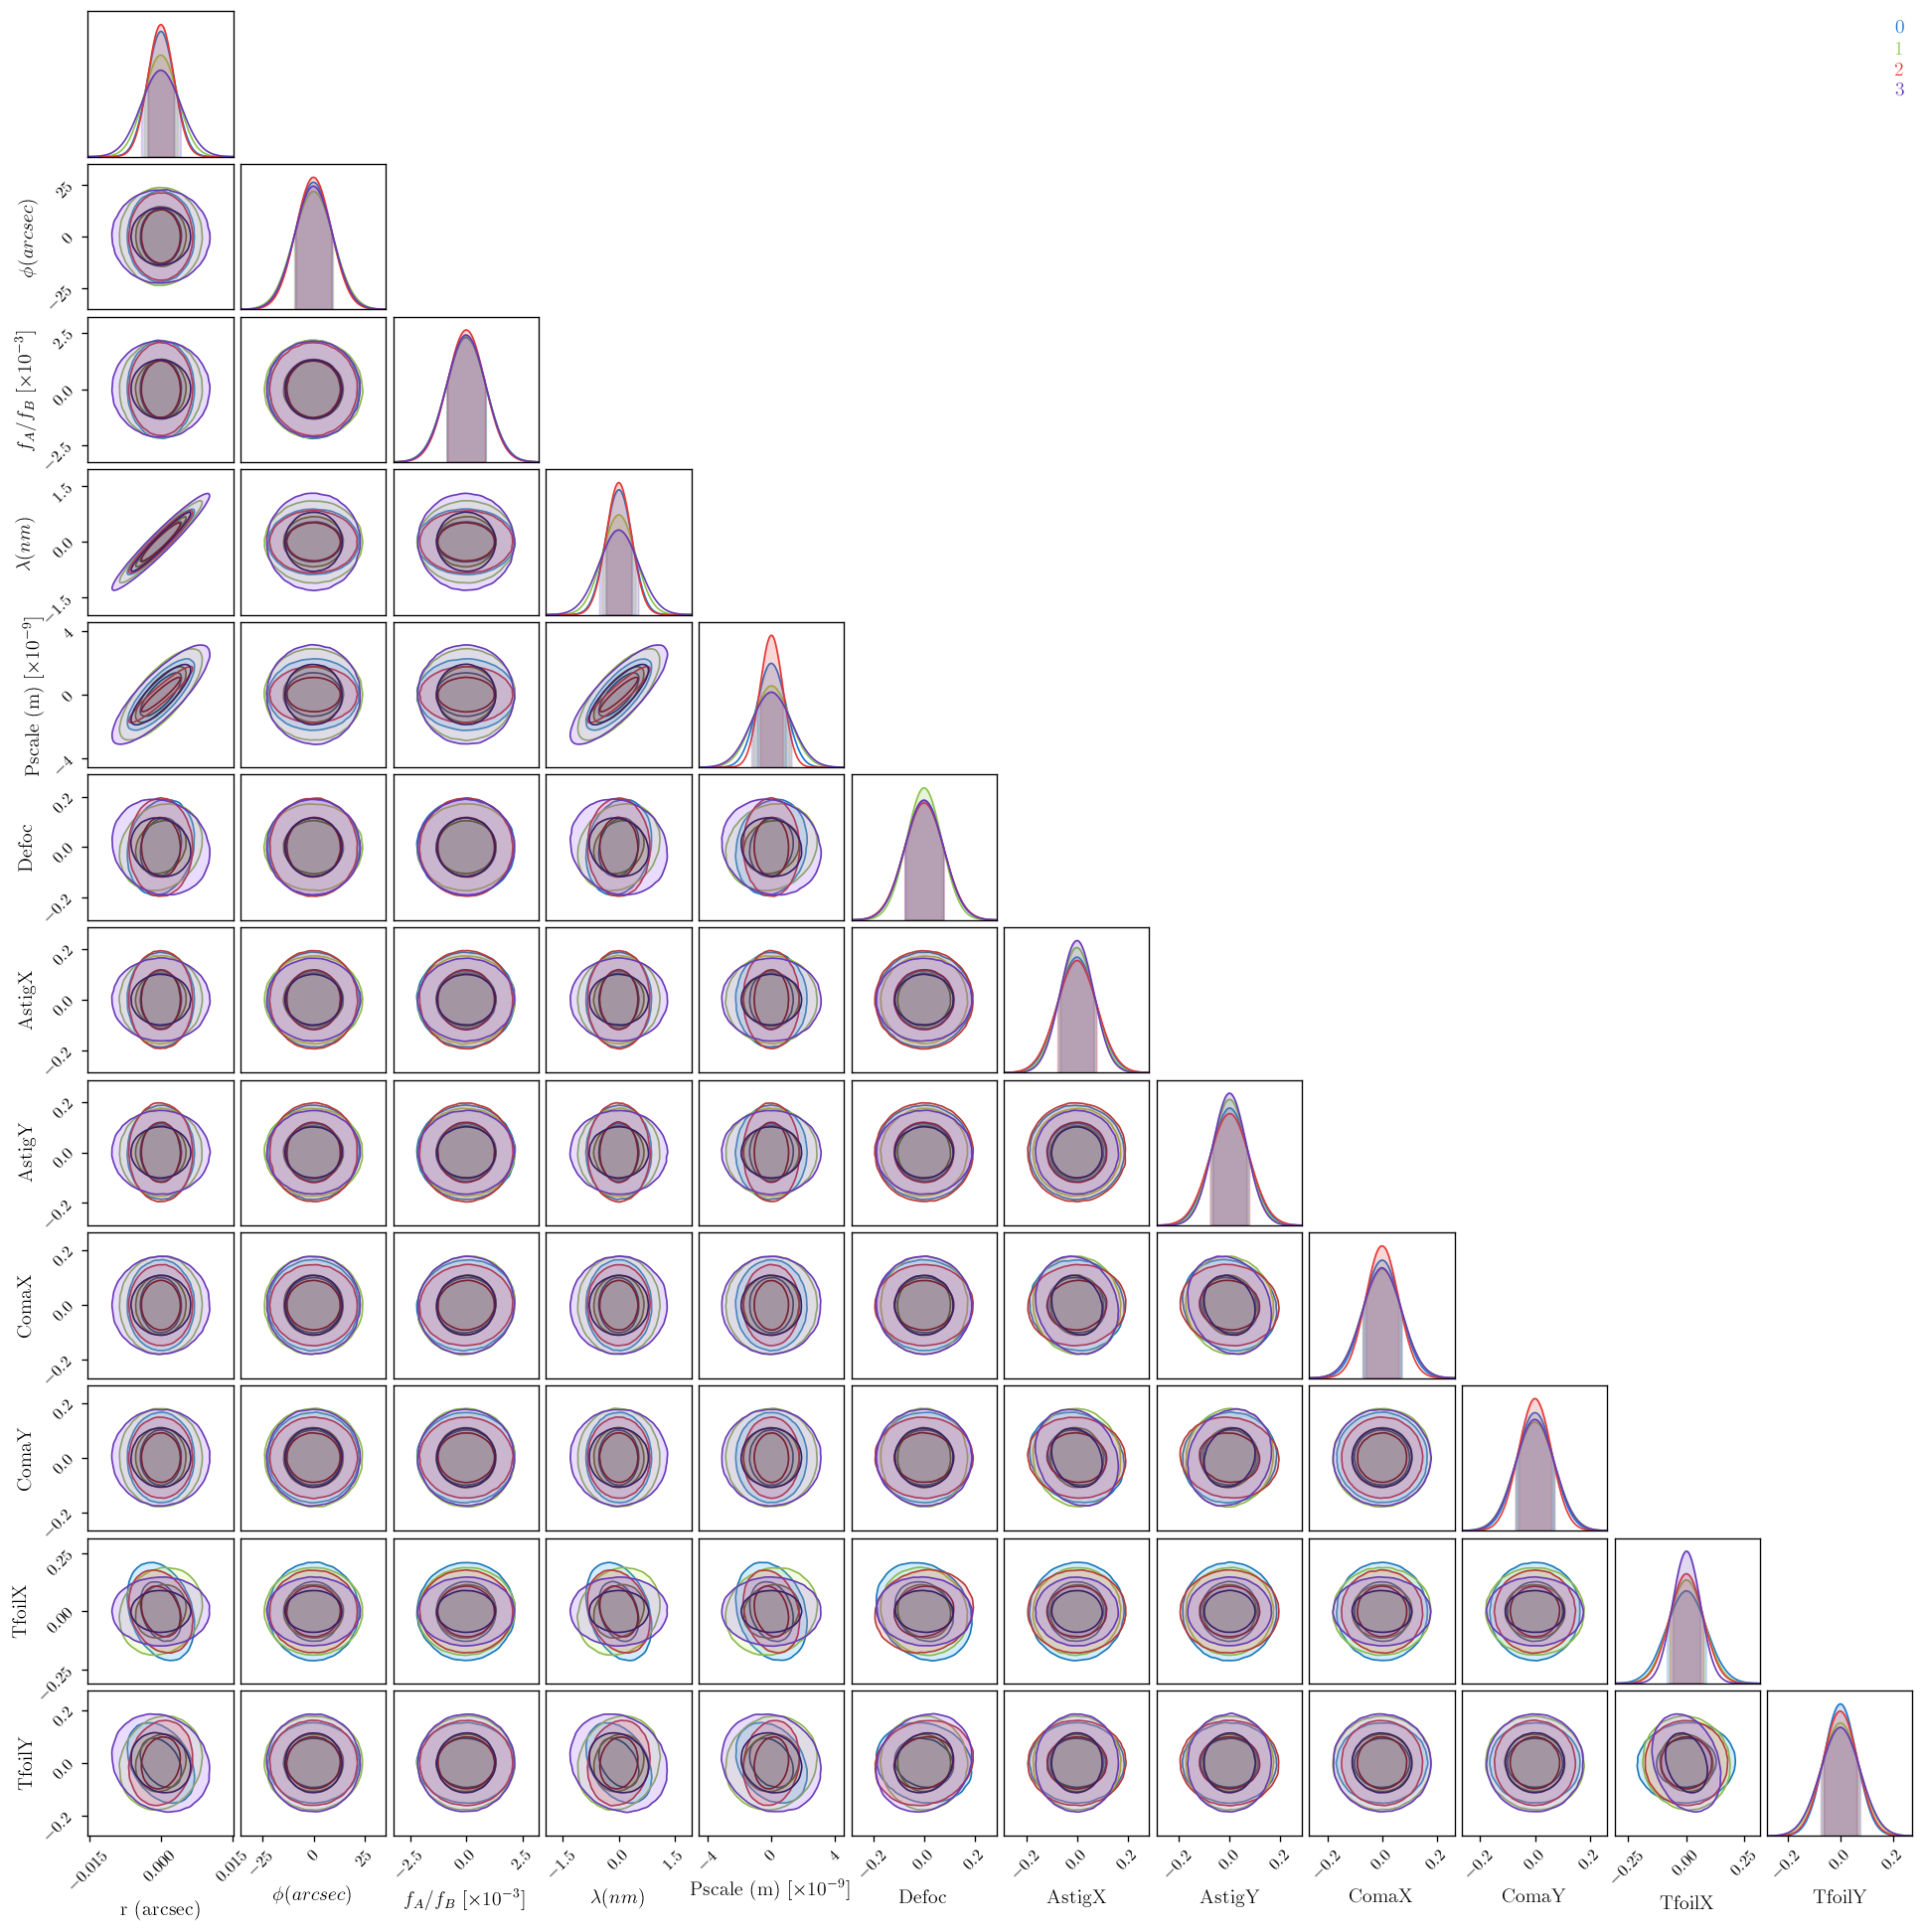

In [19]:
c = ChainConsumer()
for i in range(len(covs)):
    c.add_covariance(X, covs[i], parameters=params, name=str(i))
    
c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = c.plotter.plot_summary()
fig = c.plotter.plot()